In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import anndata as ad
import scanpy as sc
import squidpy as sq

In [2]:
in_dir = "../../results/10_stereo_seq/01_process"
out_dir = "../../results/10_stereo_seq/02_integrate_data"

os.makedirs(out_dir, exist_ok=True)

In [3]:
adata_list = []

for sample in ["HC01", "HL05", "HL25", "HL35"]:
    adata = sc.read_h5ad(f'{in_dir}/{sample}.h5ad')

    adata.obs['sample'] = sample
    
    if sample == "HC01":
        adata.obs['condition'] = 'Healthy'
    else:
        adata.obs['condition'] = 'SSc'
        
    adata_list.append(adata)

In [4]:
adata = ad.concat(adata_list, axis=0)

In [5]:
adata

AnnData object with n_obs × n_vars = 40566 × 23475
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y', 'sample', 'condition'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'

In [6]:
# update obs
adata.obs = adata.obs[["sample", "condition", "x", "y"]]

# update var
df_var = adata_list[0].var.loc[adata.var.index, ]

adata.var["real_gene_name"] = df_var['real_gene_name']
adata.var["gene_id"] = adata.var.index

adata.var.set_index('real_gene_name', inplace=True)

adata.var_names = adata.var_names.astype(str)
adata.var_names_make_unique()

In [7]:
adata

AnnData object with n_obs × n_vars = 40566 × 23475
    obs: 'sample', 'condition', 'x', 'y'
    var: 'gene_id'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'

In [8]:
adata.obs

,sample,condition,x,y
HC01_1,HC01,Healthy,10350,4550
HC01_2,HC01,Healthy,10350,4600
HC01_3,HC01,Healthy,10350,4650
HC01_4,HC01,Healthy,10350,4700
HC01_5,HC01,Healthy,10400,4350
...,...,...,...,...
HL35_9108,HL35,SSc,8250,17600
HL35_9109,HL35,SSc,8250,17650
HL35_9110,HL35,SSc,8300,17450
HL35_9111,HL35,SSc,8300,17500


In [9]:
adata.raw = adata.copy()

In [10]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

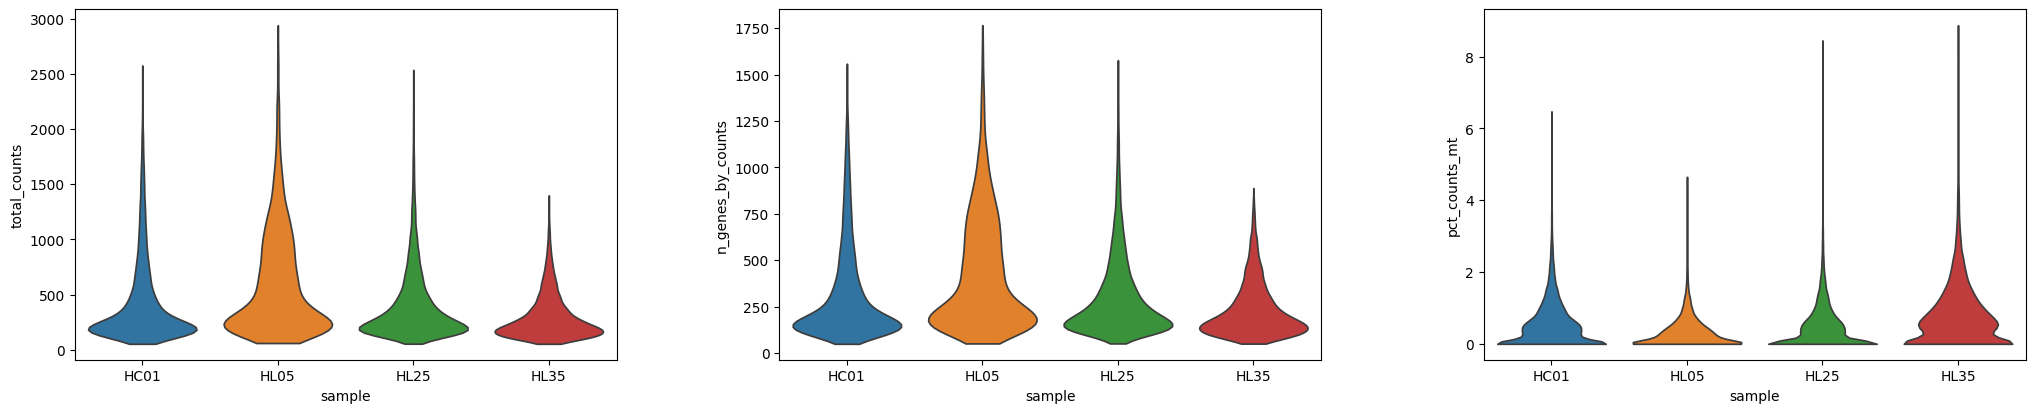

In [11]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, groupby='sample', size=0)

In [12]:
sc.pp.filter_genes(adata, min_cells=100)

In [13]:
adata

AnnData object with n_obs × n_vars = 40566 × 13649
    obs: 'sample', 'condition', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'
    uns: 'sample_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'

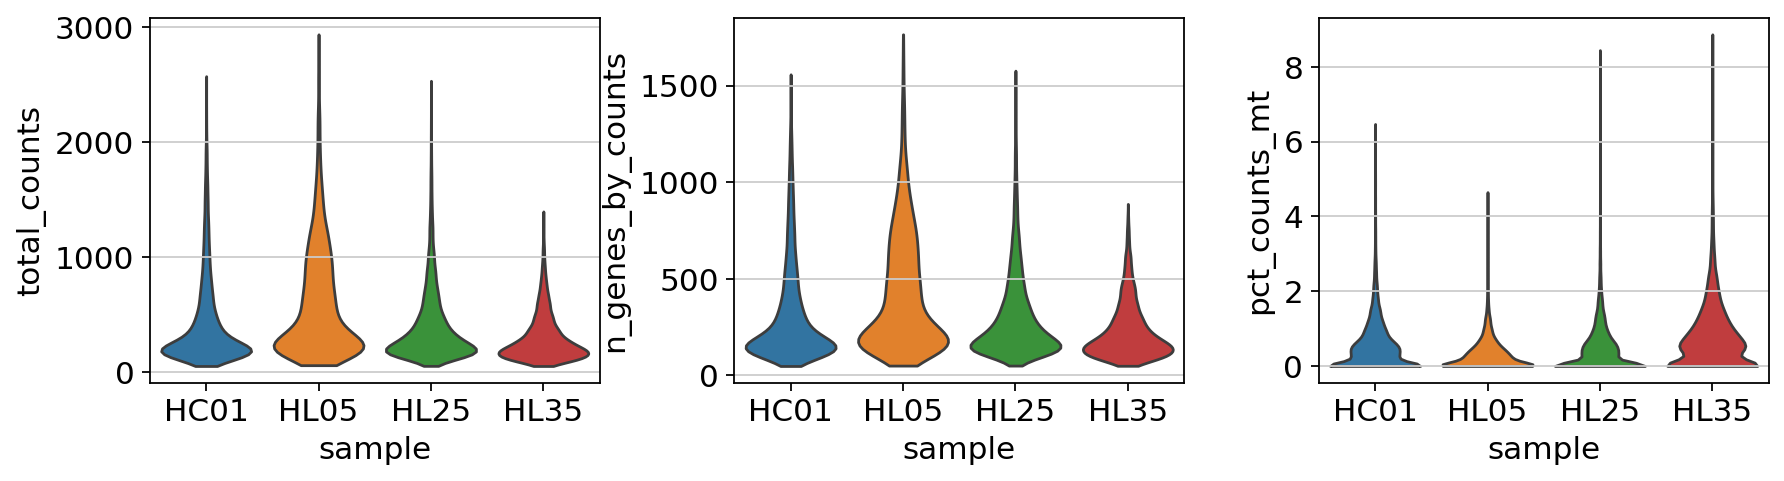

In [14]:
sc.set_figure_params(figsize=(4, 3))

sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, groupby='sample', size=0)

In [15]:
adata

AnnData object with n_obs × n_vars = 40566 × 13649
    obs: 'sample', 'condition', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'
    uns: 'sample_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'

In [16]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2024-12-31 23:10:58.643925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735686658.828341  612056 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735686658.884337  612056 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 23:10:59.829747: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


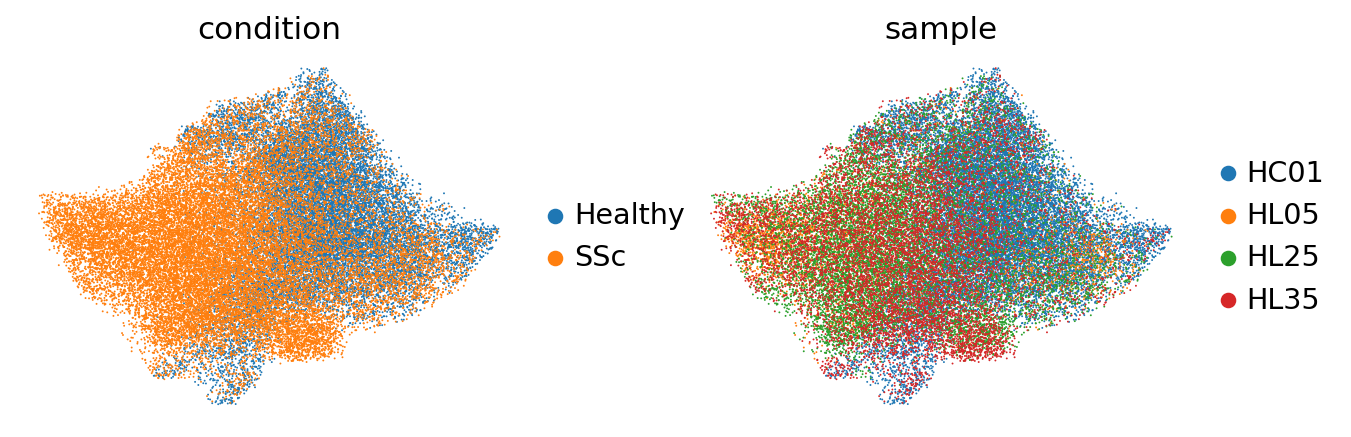

In [17]:
sc.pl.umap(adata, color=['condition', 'sample'], frameon=False)

In [18]:
# batch correction
from scipy.cluster.vq import kmeans2
import harmonypy as hm
import numpy as np

def cluster_fn(data, K):
    centroid, label = kmeans2(data, K, minit='++')
    return centroid

X = adata.obsm['X_pca'].astype(np.float64)

harmony_out = hm.run_harmony(X, adata.obs,
                             ['sample'], cluster_fn=cluster_fn, max_iter_harmony=20)

adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

2024-12-31 23:12:15,272 - harmonypy - INFO - Iteration 1 of 20
2024-12-31 23:12:25,975 - harmonypy - INFO - Iteration 2 of 20
2024-12-31 23:12:36,482 - harmonypy - INFO - Converged after 2 iterations


In [19]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

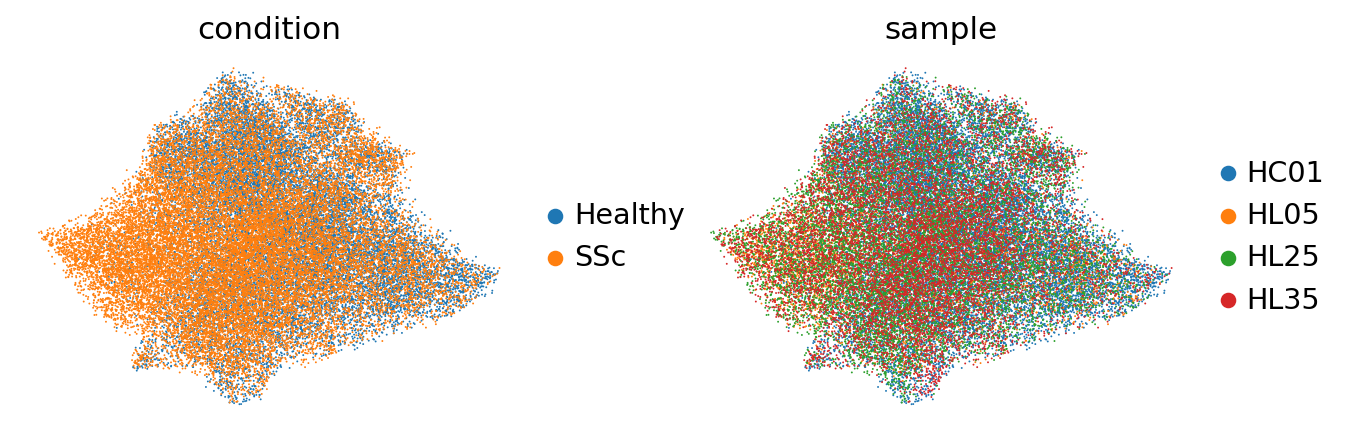

In [20]:
sc.pl.umap(adata, color=['condition', 'sample'], frameon=False)

In [21]:
adata.write_h5ad(f"{out_dir}/adata.h5ad")